In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.special import expit  # sigmoid
from scipy.stats import norm


In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927

rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
file= "mayflies_salt_survival.csv"

In [4]:
df =  pd.read_csv(file)


In [5]:
df.head()

,N0,Nsurv,conc,Salt
0,9,9,1,NaCl
1,4,4,2,NaCl
2,5,5,4,NaCl
3,6,6,8,NaCl
4,9,7,16,NaCl


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   N0      99 non-null     int64 
 1   Nsurv   99 non-null     int64 
 2   conc    99 non-null     int64 
 3   Salt    99 non-null     object
dtypes: int64(3), object(1)
memory usage: 3.2+ KB


In [7]:
df.describe()

,N0,Nsurv,conc
count,99.000000,99.000000,99.000000
mean,6.090909,2.868687,186.090909
std,2.181045,2.848725,305.636776
min,1.000000,0.000000,1.000000
25%,5.000000,0.000000,4.000000
50%,6.000000,2.000000,32.000000
75%,8.000000,5.000000,256.000000
max,13.000000,11.000000,1024.000000


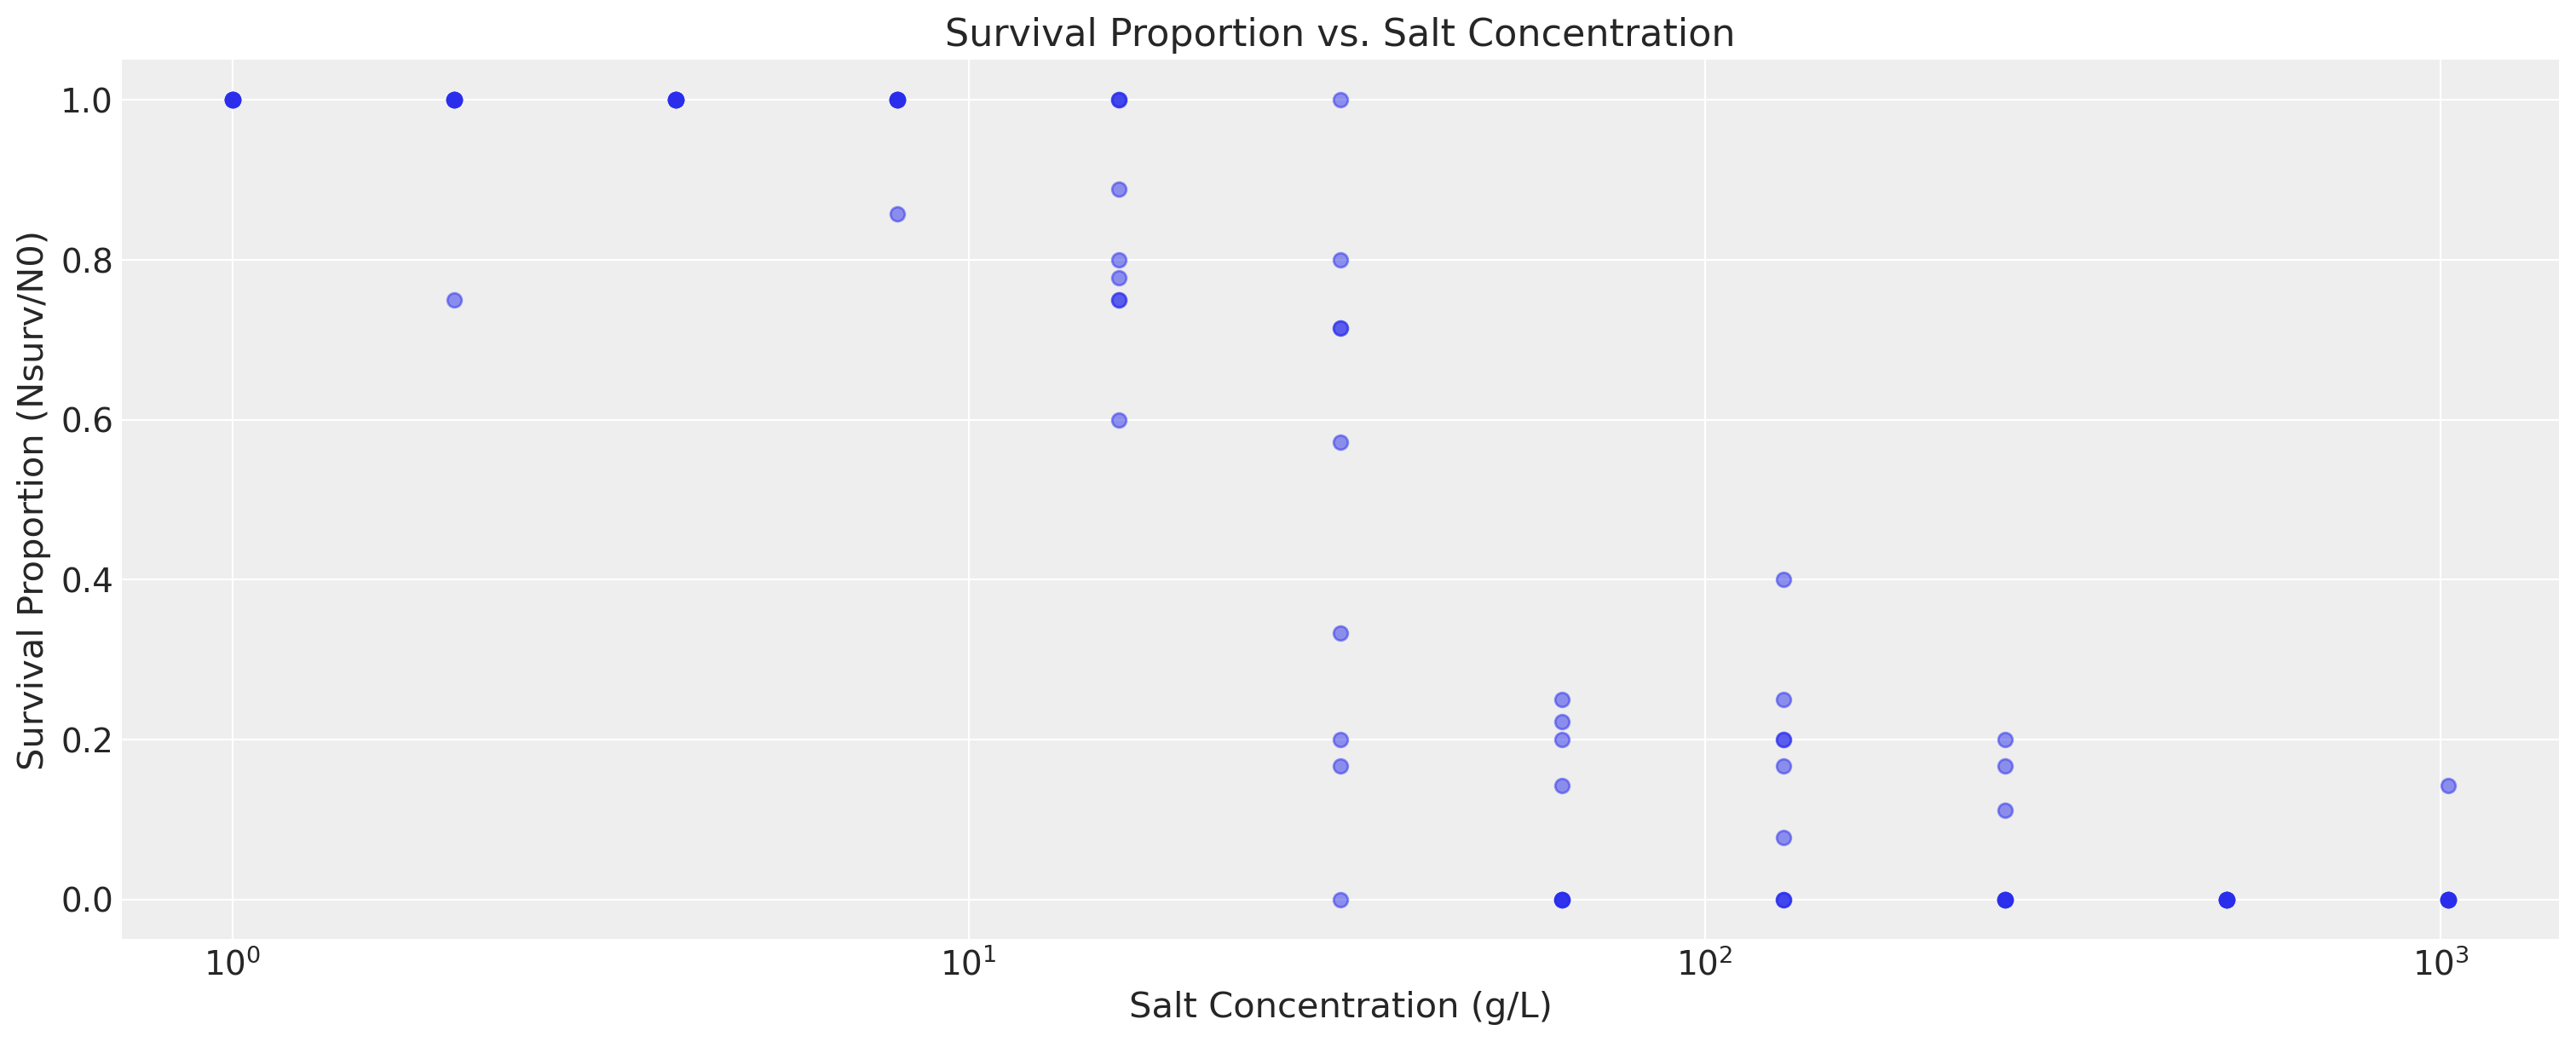

In [8]:
df['survival_proportion'] = df["Nsurv"]/df['N0']
df
plt.figure(figsize=(15, 6))
plt.scatter(df["conc"], df["survival_proportion"], alpha=0.5)
plt.xlabel("Salt Concentration (g/L)")
plt.xscale("log")
plt.ylabel("Survival Proportion (Nsurv/N0)")
plt.title("Survival Proportion vs. Salt Concentration")
plt.grid(True)
plt.show()

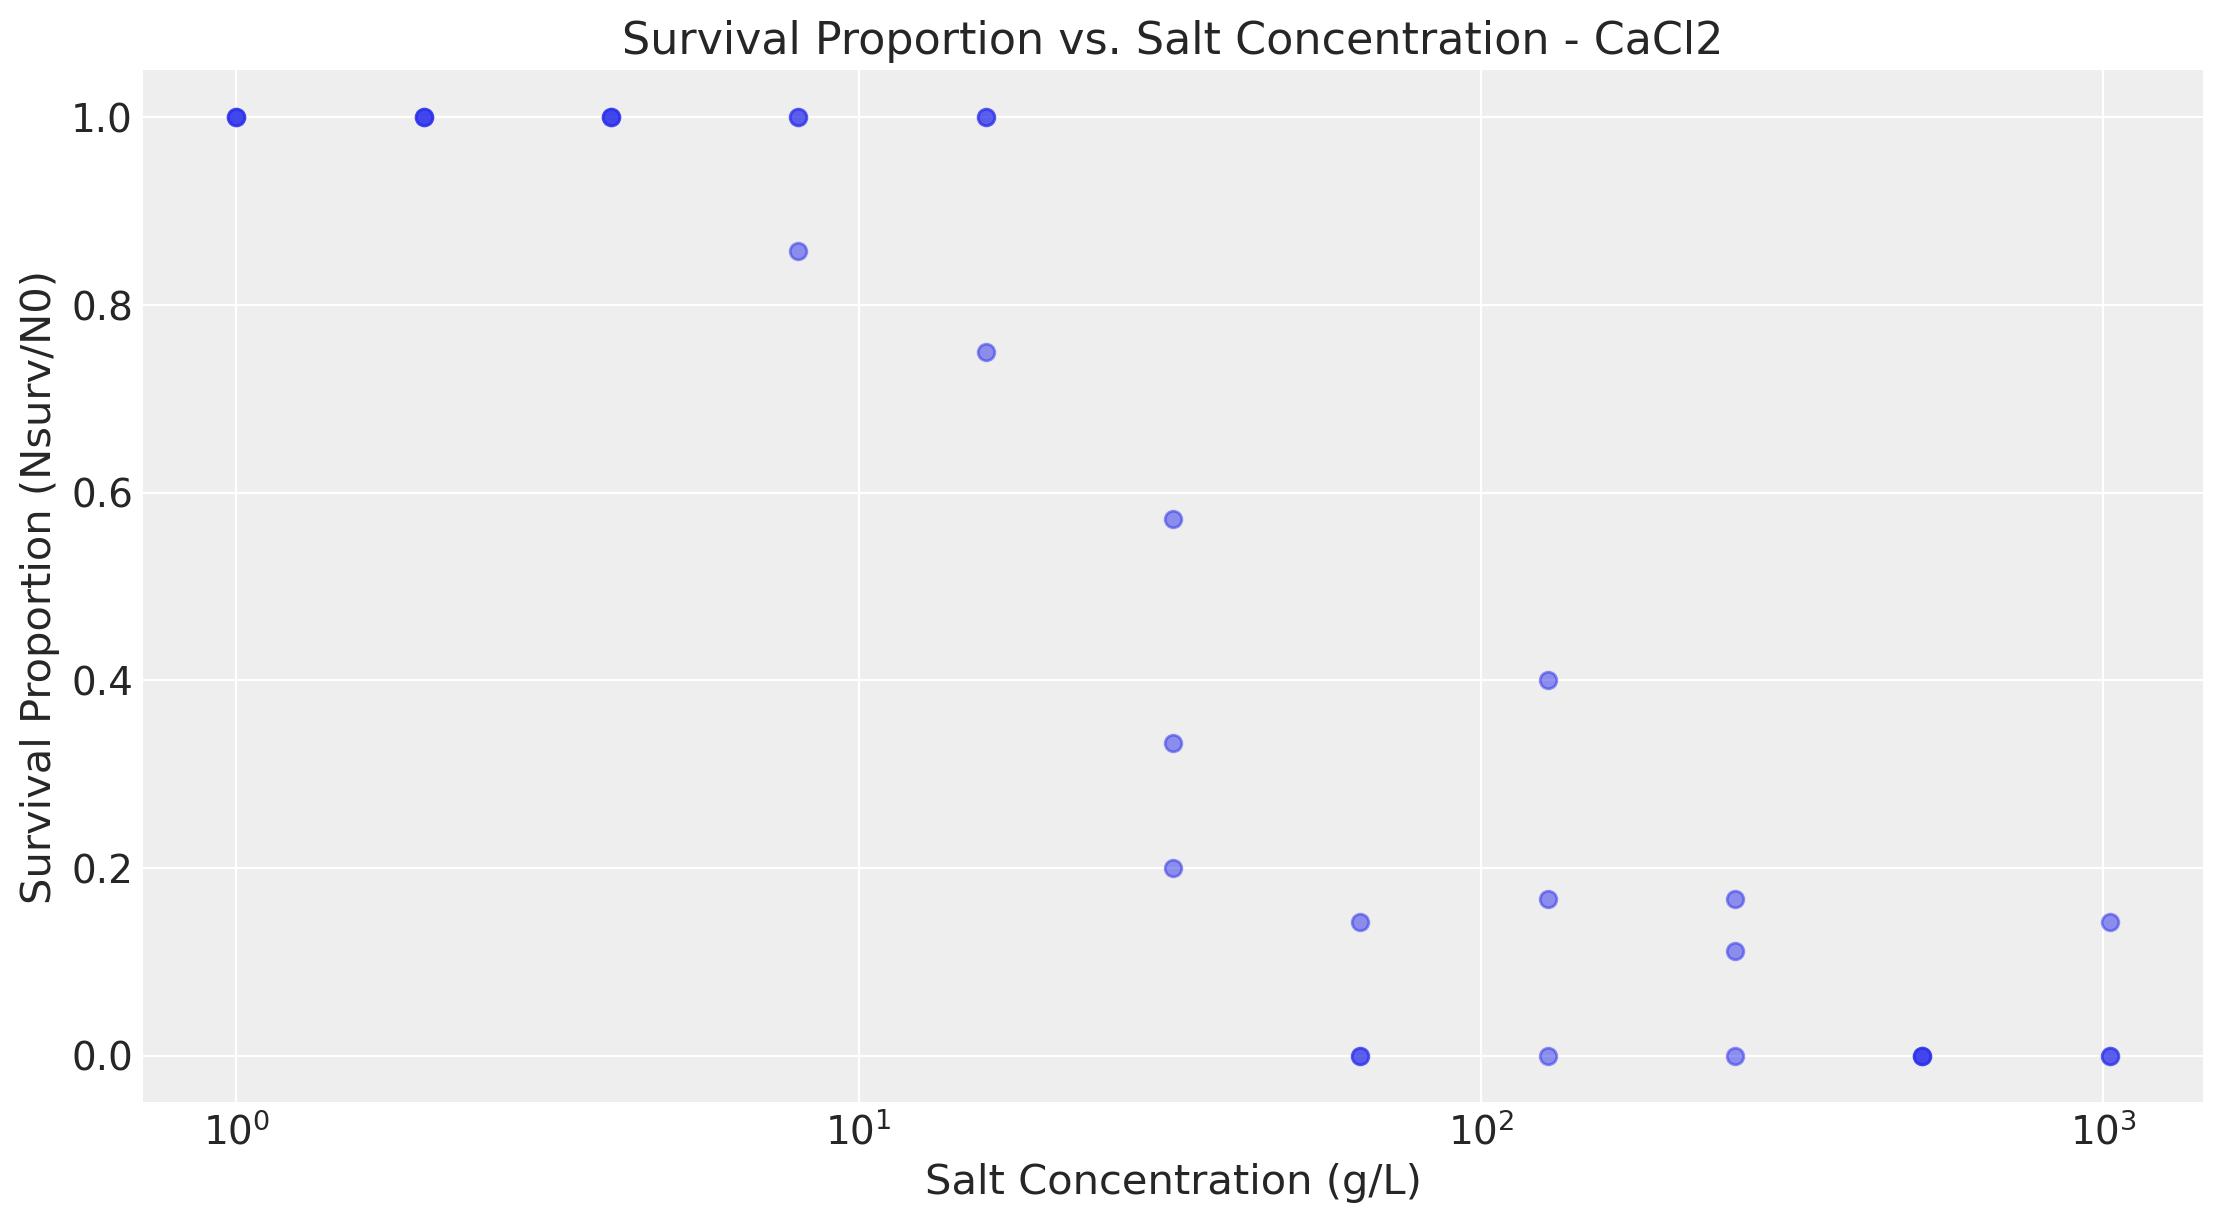

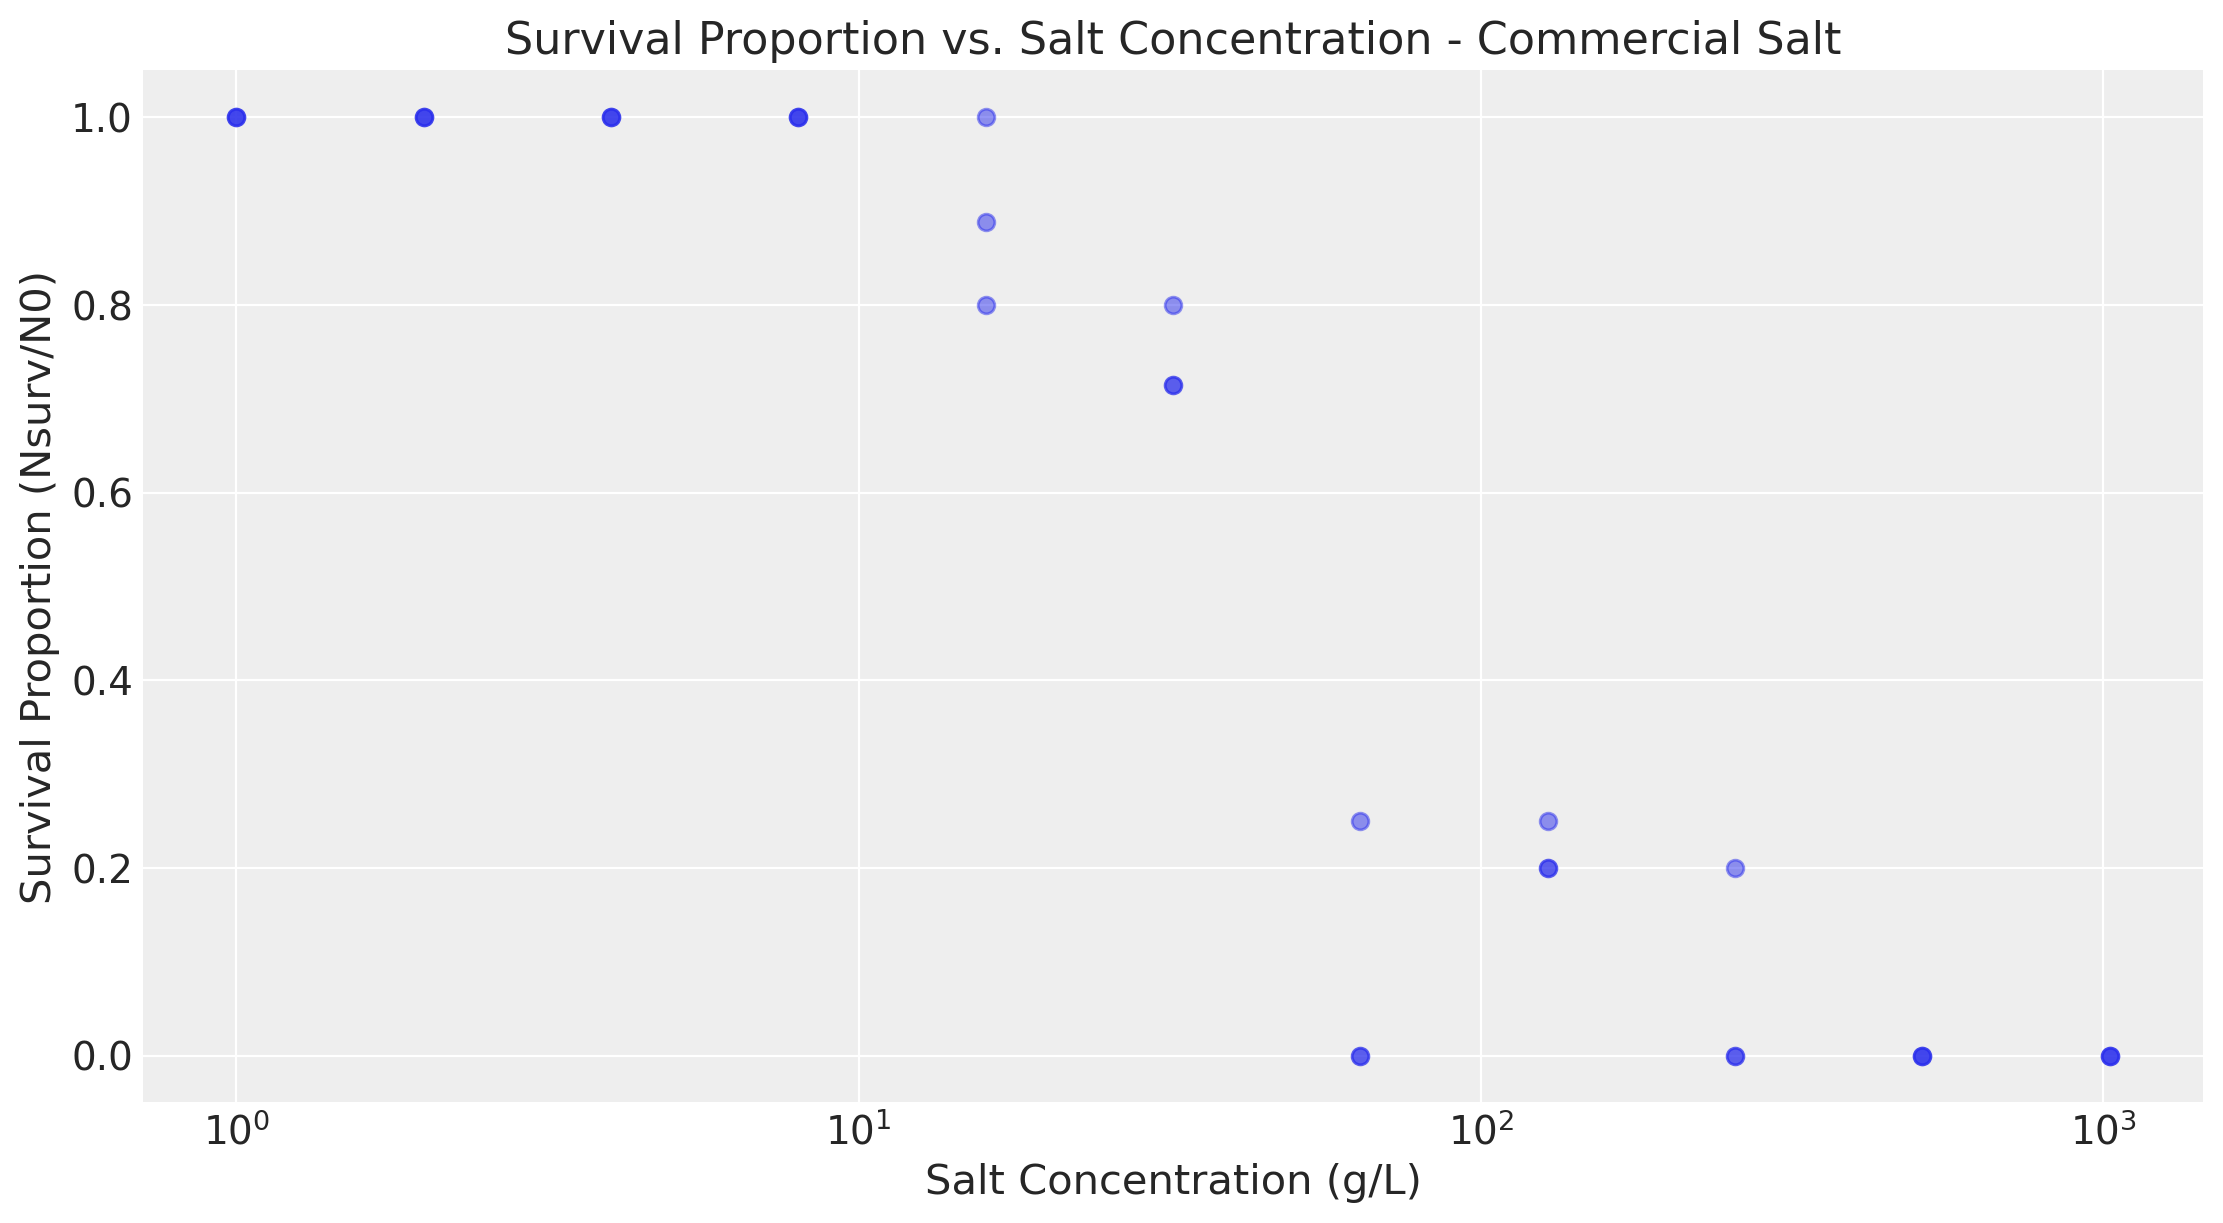

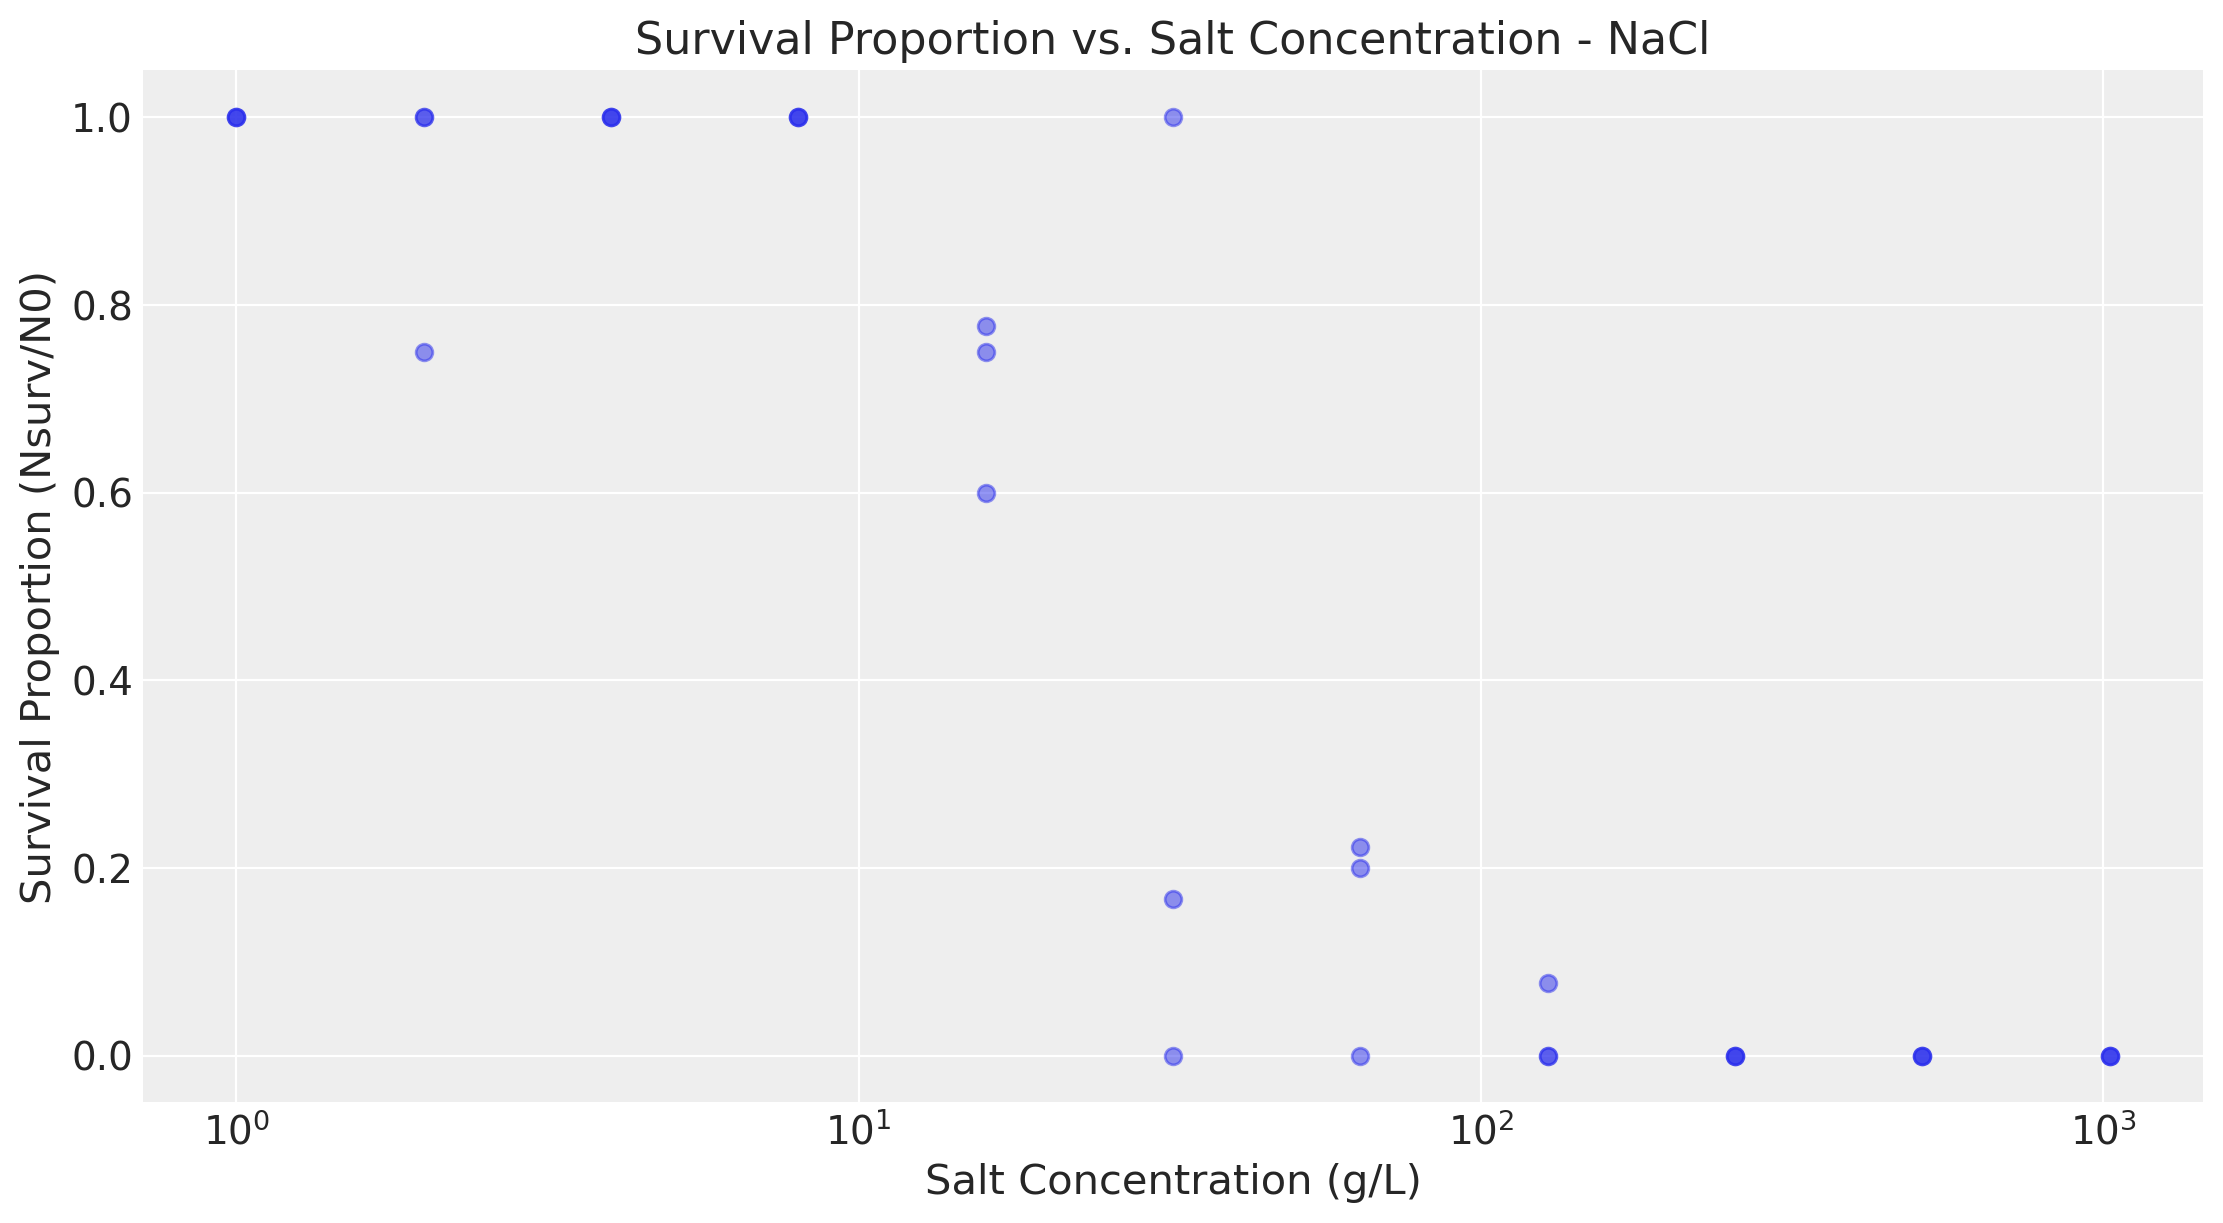

In [9]:
for salt_type, group in df.groupby('Salt'):
    plt.figure(figsize=(11, 6))
    plt.scatter(group['conc'], group['survival_proportion'], alpha=0.5)
    plt.xlabel("Salt Concentration (g/L)")
    plt.xscale('log')
    plt.ylabel("Survival Proportion (Nsurv/N0)")
    plt.title(f"Survival Proportion vs. Salt Concentration - {salt_type}")
    plt.grid(True)
    plt.show()

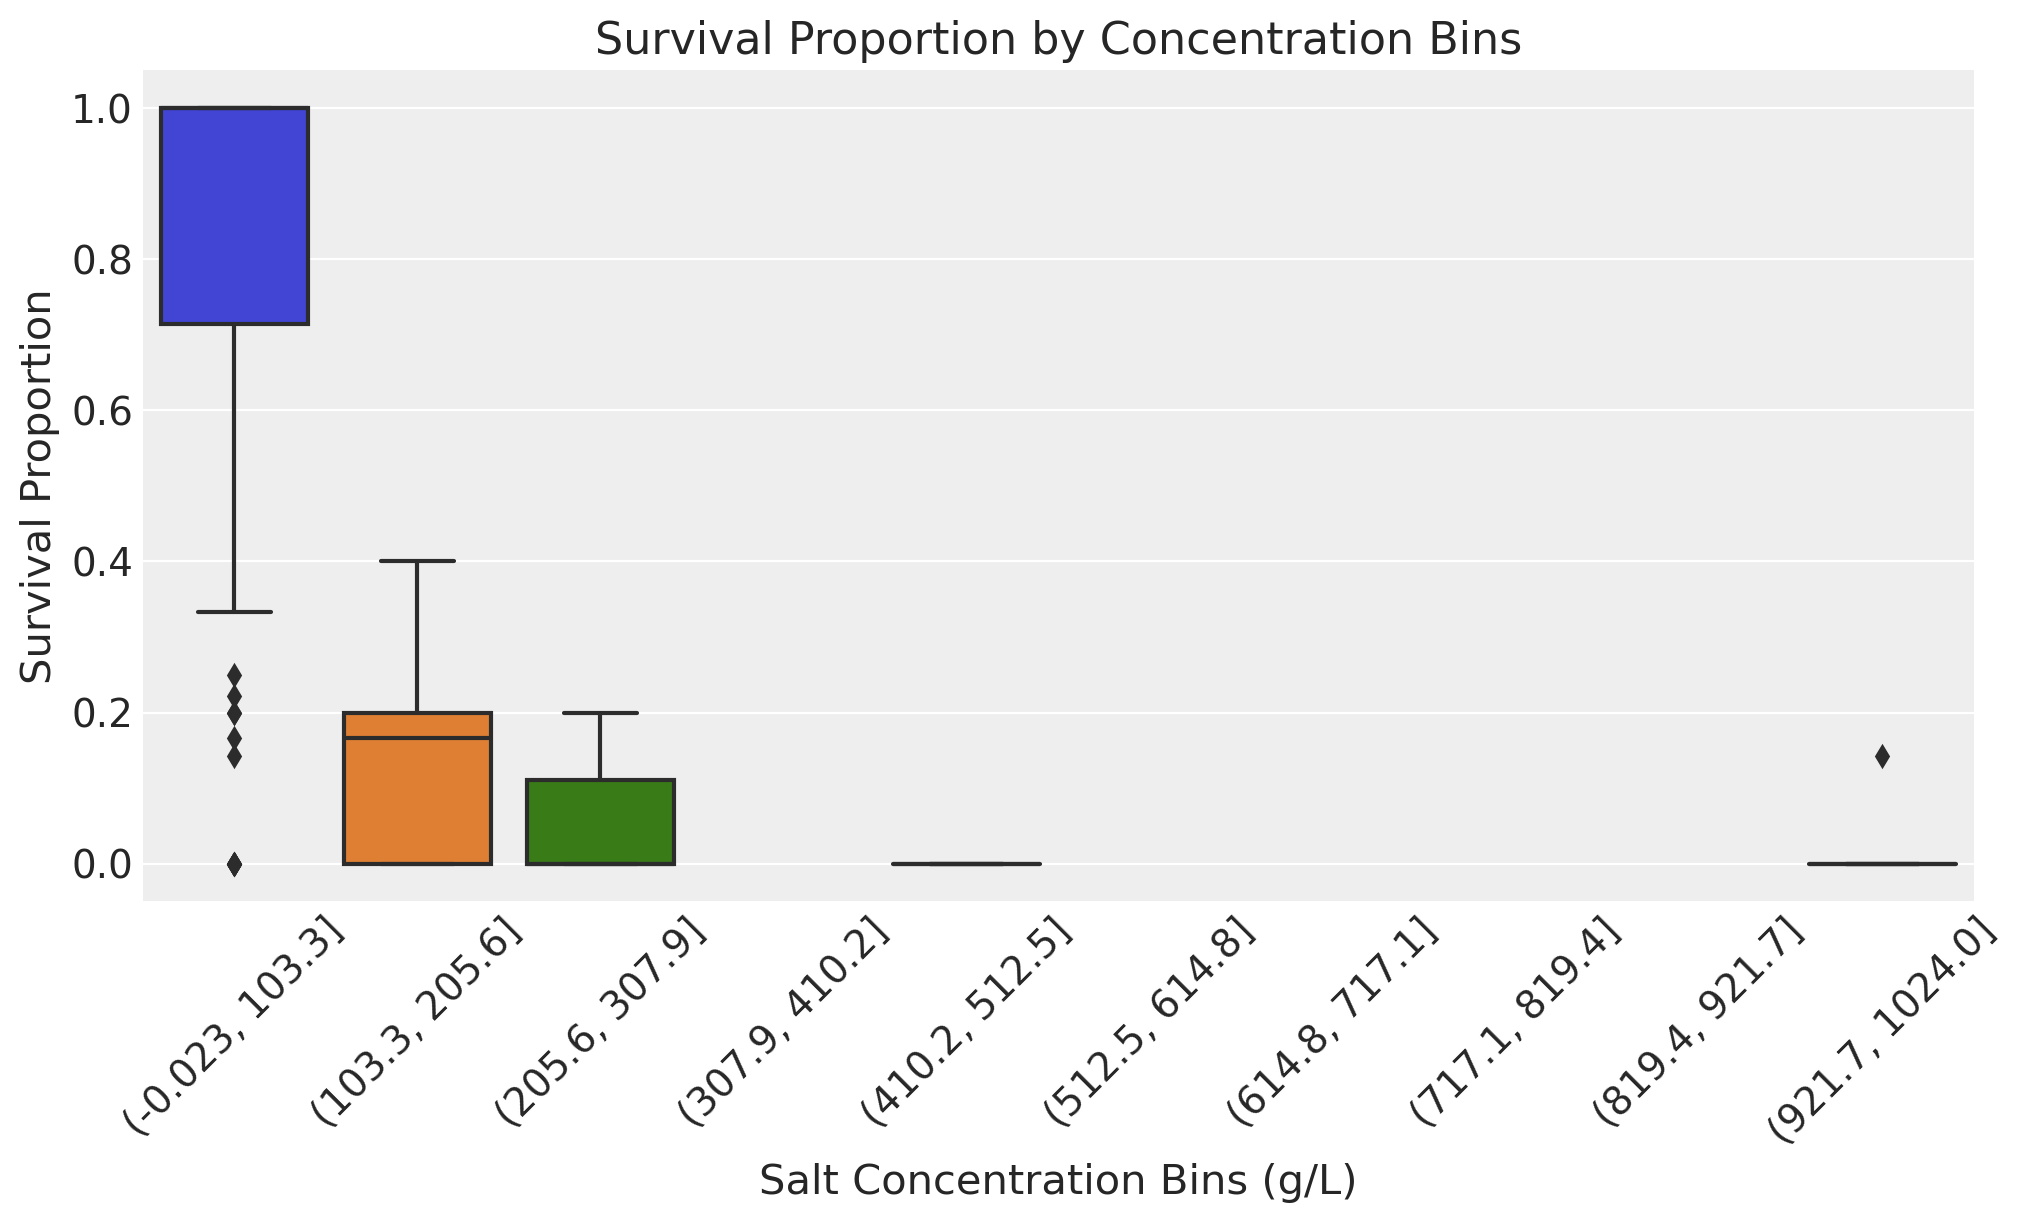

In [10]:

df["conc_bin"] = pd.cut(df["conc"], bins=10)

plt.figure(figsize=(10, 6))
sns.boxplot(x="conc_bin", y="survival_proportion", data=df)
plt.xlabel("Salt Concentration Bins (g/L)")
plt.ylabel("Survival Proportion")
plt.title("Survival Proportion by Concentration Bins")
plt.xticks(rotation=45)
plt.show()

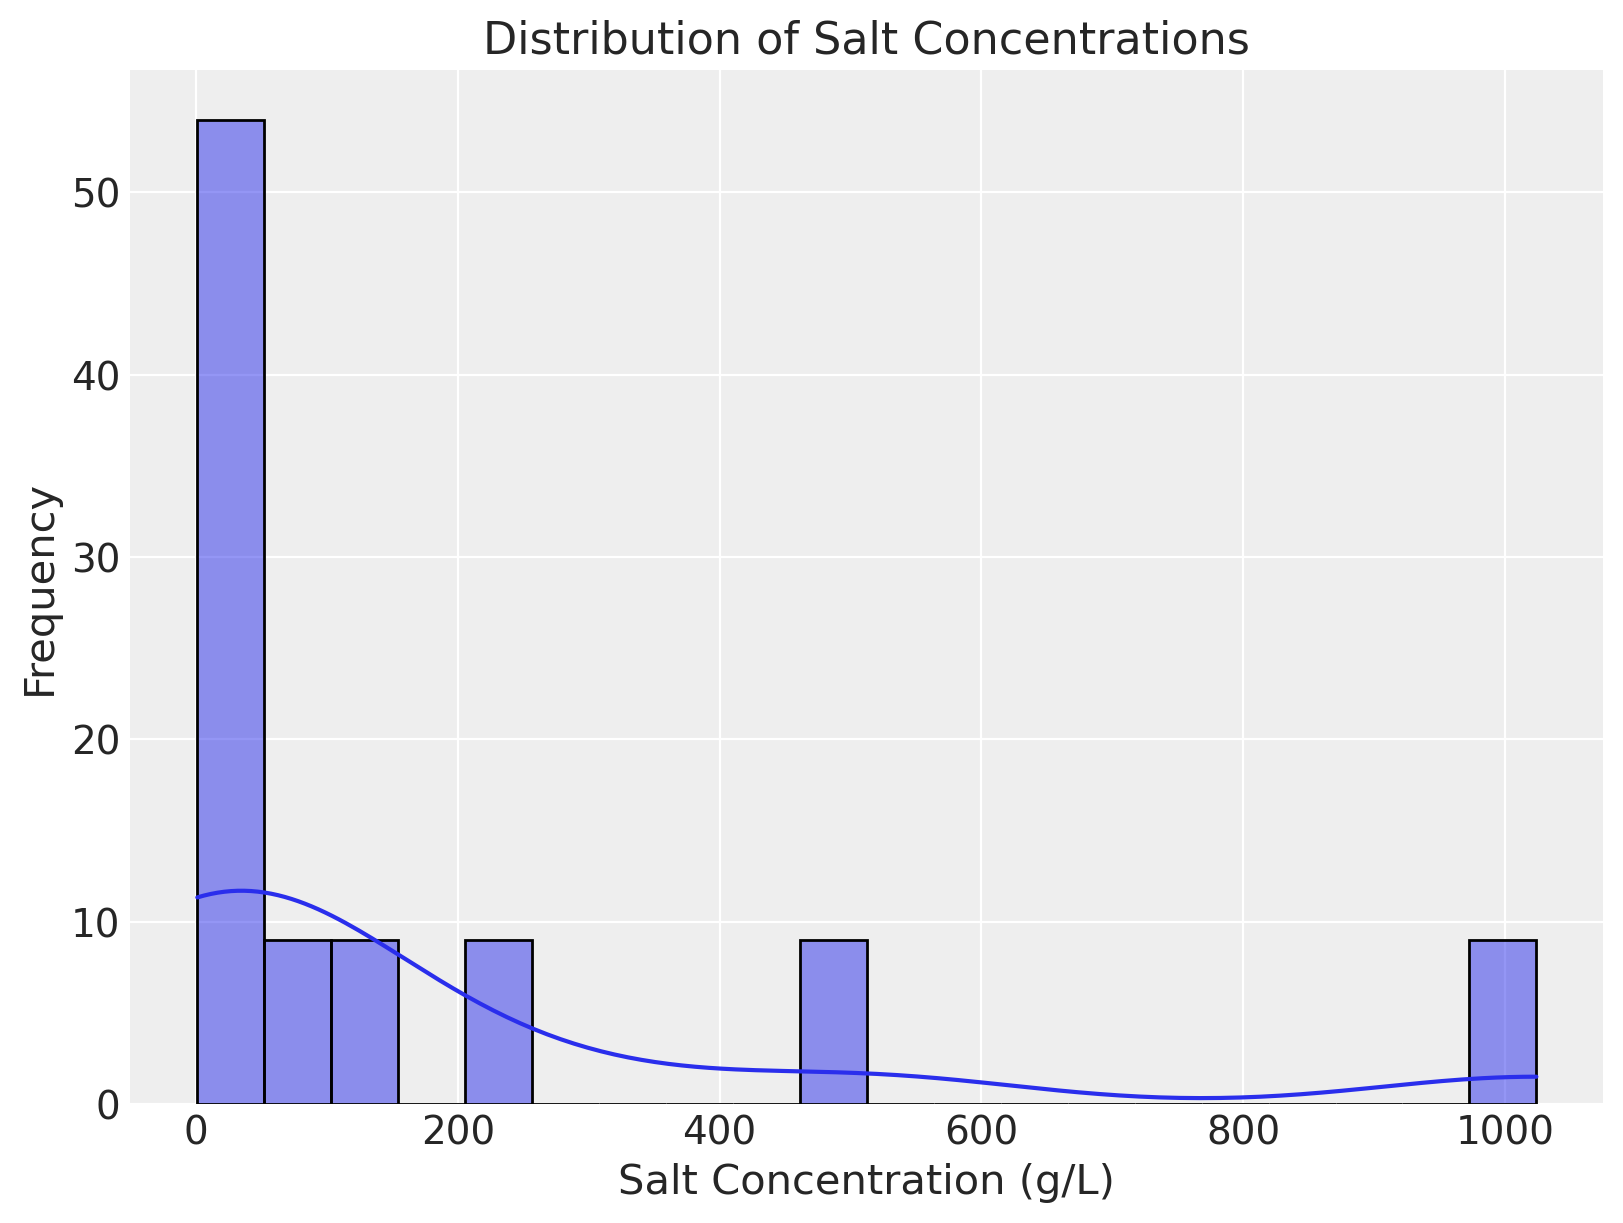

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(df["conc"], bins=20, kde=True)
plt.xlabel("Salt Concentration (g/L)")
plt.xlabel("Salt Concentration (g/L)")
# plt.xscale("log")
plt.ylabel("Frequency")
plt.title("Distribution of Salt Concentrations")
plt.show()

### Bayesian Logistic Regression Model

In [12]:
conc_normed = (df['conc'] - df['conc'].mean()) /df['conc'].std()

In [13]:
conc_normed

0    -0.605591
1    -0.602319
2    -0.595776
3    -0.582688
4    -0.556513
        ...   
94   -0.399464
95   -0.190065
96    0.228733
97    1.066328
98    2.741519
Name: conc, Length: 99, dtype: float64

In [14]:
log_reg_logit= pm.Model()

with log_reg_logit: #creating a context manager
    # Priors 
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    
    # Logit function: logit(p) = beta_0 + beta_1 * log(conc)
    logit_p = beta_0 + beta_1 * np.log(df['conc'])
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))  # Logistic (sigmoid) link function
   

    # Likelihood (Binomial distribution)
    Nsurv_obs = pm.Binomial("Nsurv", n=df['N0'], p=p, observed=df['Nsurv'])

    # Sampling from the posterior
    log_reg_logit_trace = pm.sample(5000, tune=1000, return_inferencedata=True, target_accept=0.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [15]:
with log_reg_logit:
    print(log_reg_logit.named_vars)   # Liste des variables aléatoires
  
    print(log_reg_logit.basic_RVs)

{'beta_0': beta_0, 'beta_1': beta_1, 'p': p, 'Nsurv': Nsurv}
[beta_0, beta_1, Nsurv]


    1000 tuning samples (warm-up sample) + une variante de Hamiltonian Monte Carlo (HMC)

In [16]:
az.summary(log_reg_logit_trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,6.762,0.596,5.662,7.863,0.011,0.008,3122.0,4112.0,1.0
beta_1,-1.913,0.160,-2.203,-1.615,0.003,0.002,3111.0,4189.0,1.0
p[0],0.999,0.001,0.997,1.000,0.000,0.000,3122.0,4112.0,1.0
p[1],0.995,0.002,0.991,0.999,0.000,0.000,3175.0,4197.0,1.0
p[2],0.983,0.007,0.970,0.993,0.000,0.000,3299.0,4437.0,1.0
...,...,...,...,...,...,...,...,...,...
p[94],0.234,0.032,0.174,0.292,0.000,0.000,11042.0,11629.0,1.0
p[95],0.076,0.018,0.044,0.109,0.000,0.000,5297.0,7571.0,1.0
p[96],0.022,0.007,0.009,0.036,0.000,0.000,4146.0,6140.0,1.0
p[97],0.006,0.003,0.002,0.011,0.000,0.000,3738.0,5270.0,1.0


/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

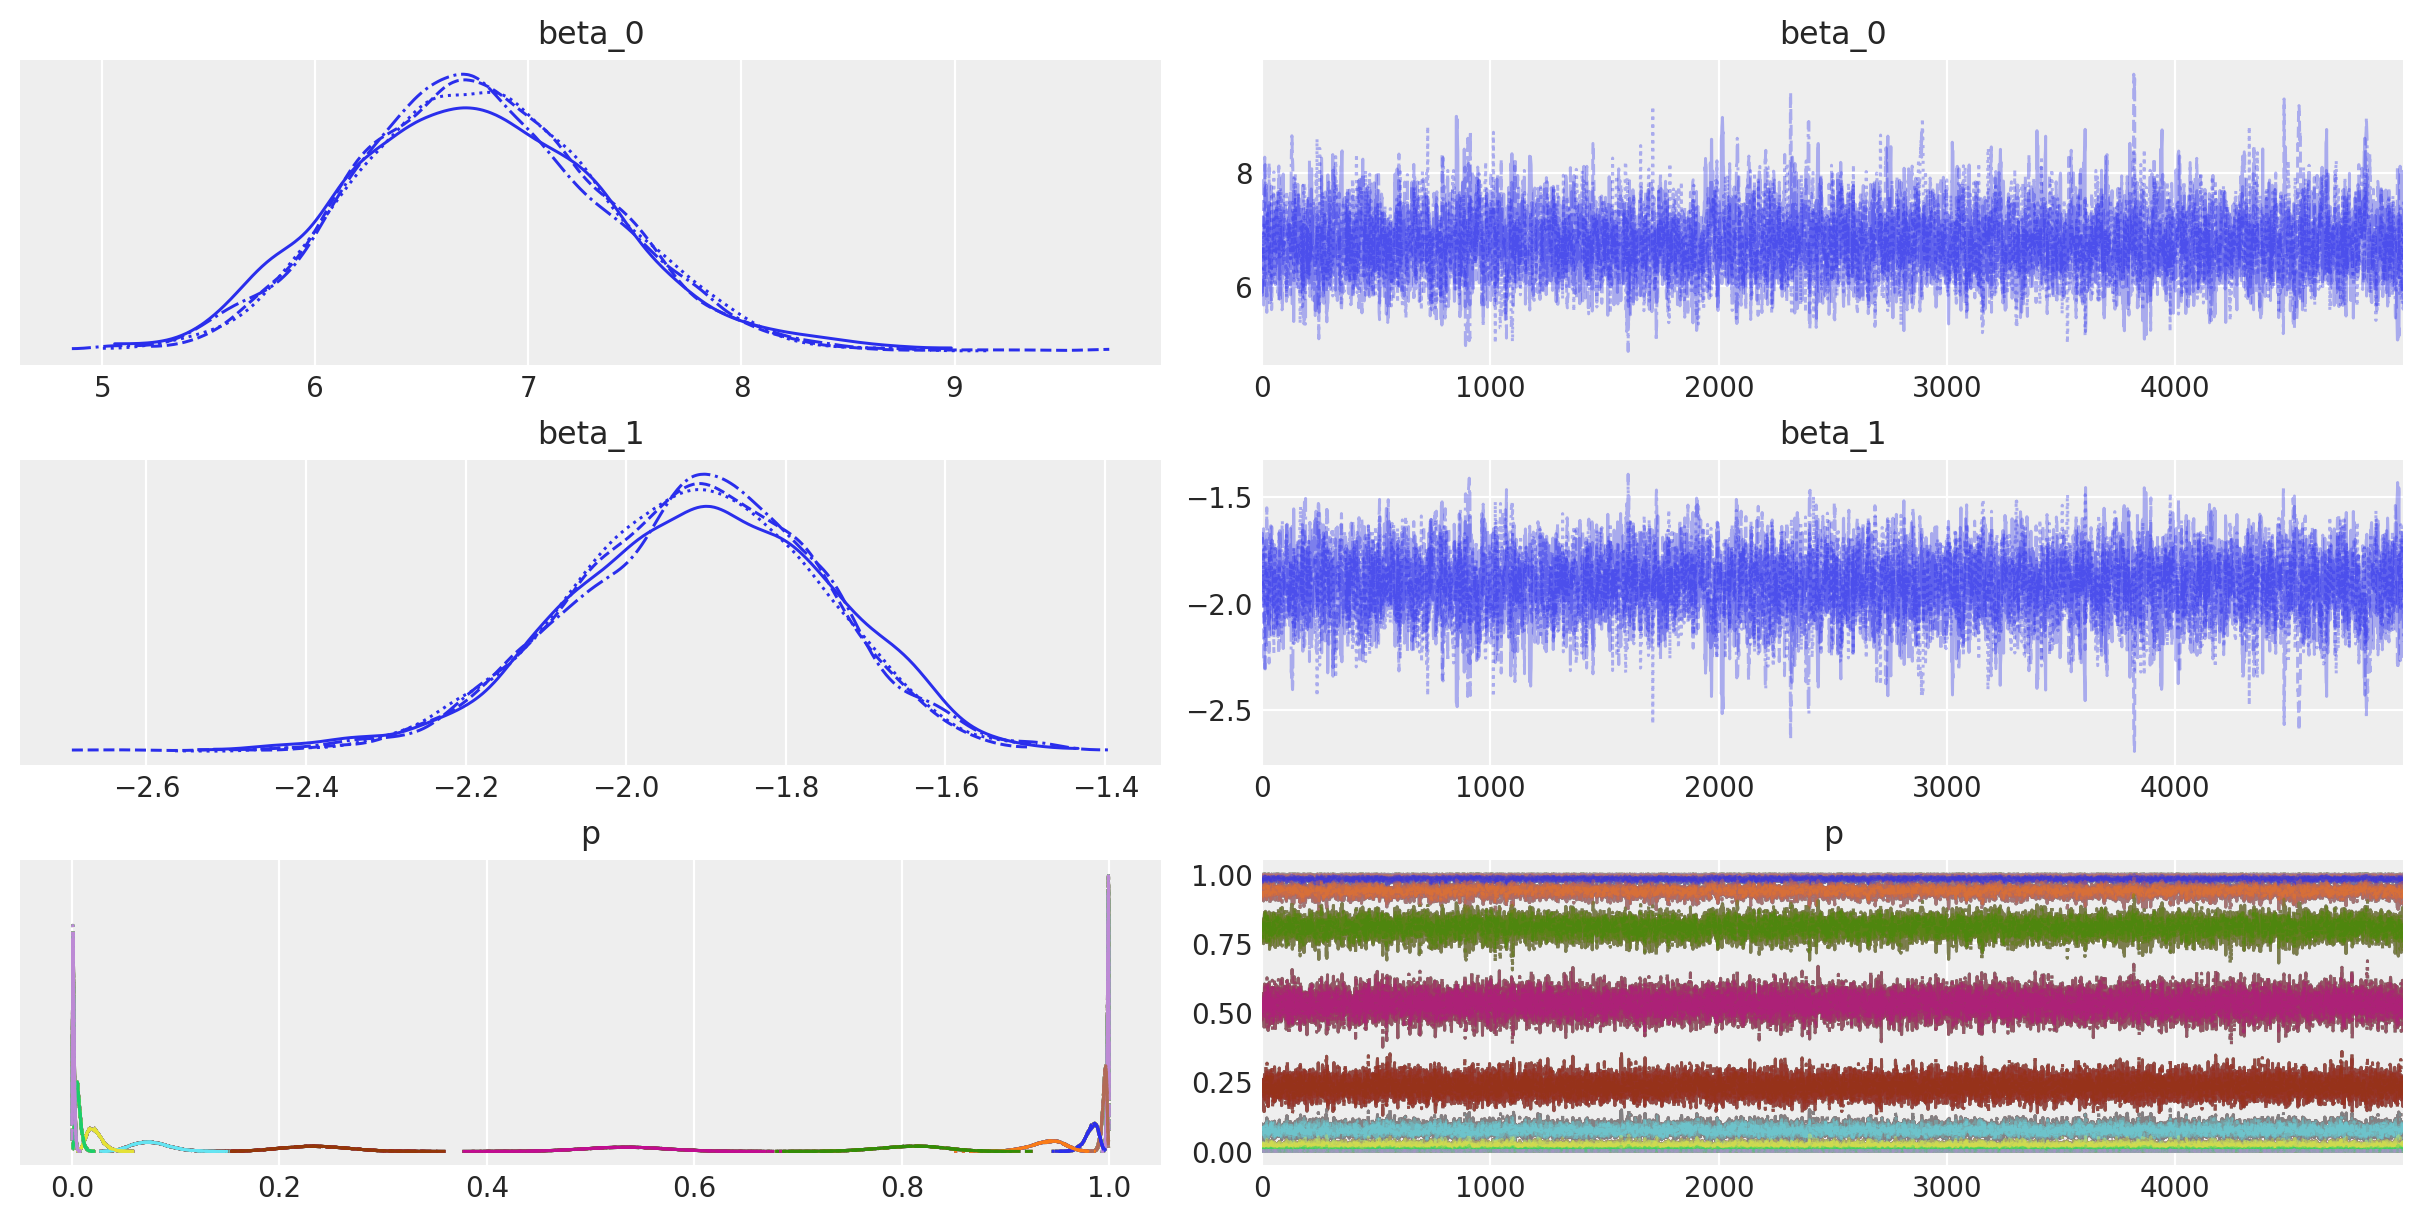

In [17]:
az.plot_trace(log_reg_logit_trace) #traces temporelles  
# le troisieme c'est quelque variables latentes dans le modele bayesien

In [18]:
# az.plot_posterior(log_reg_trace)


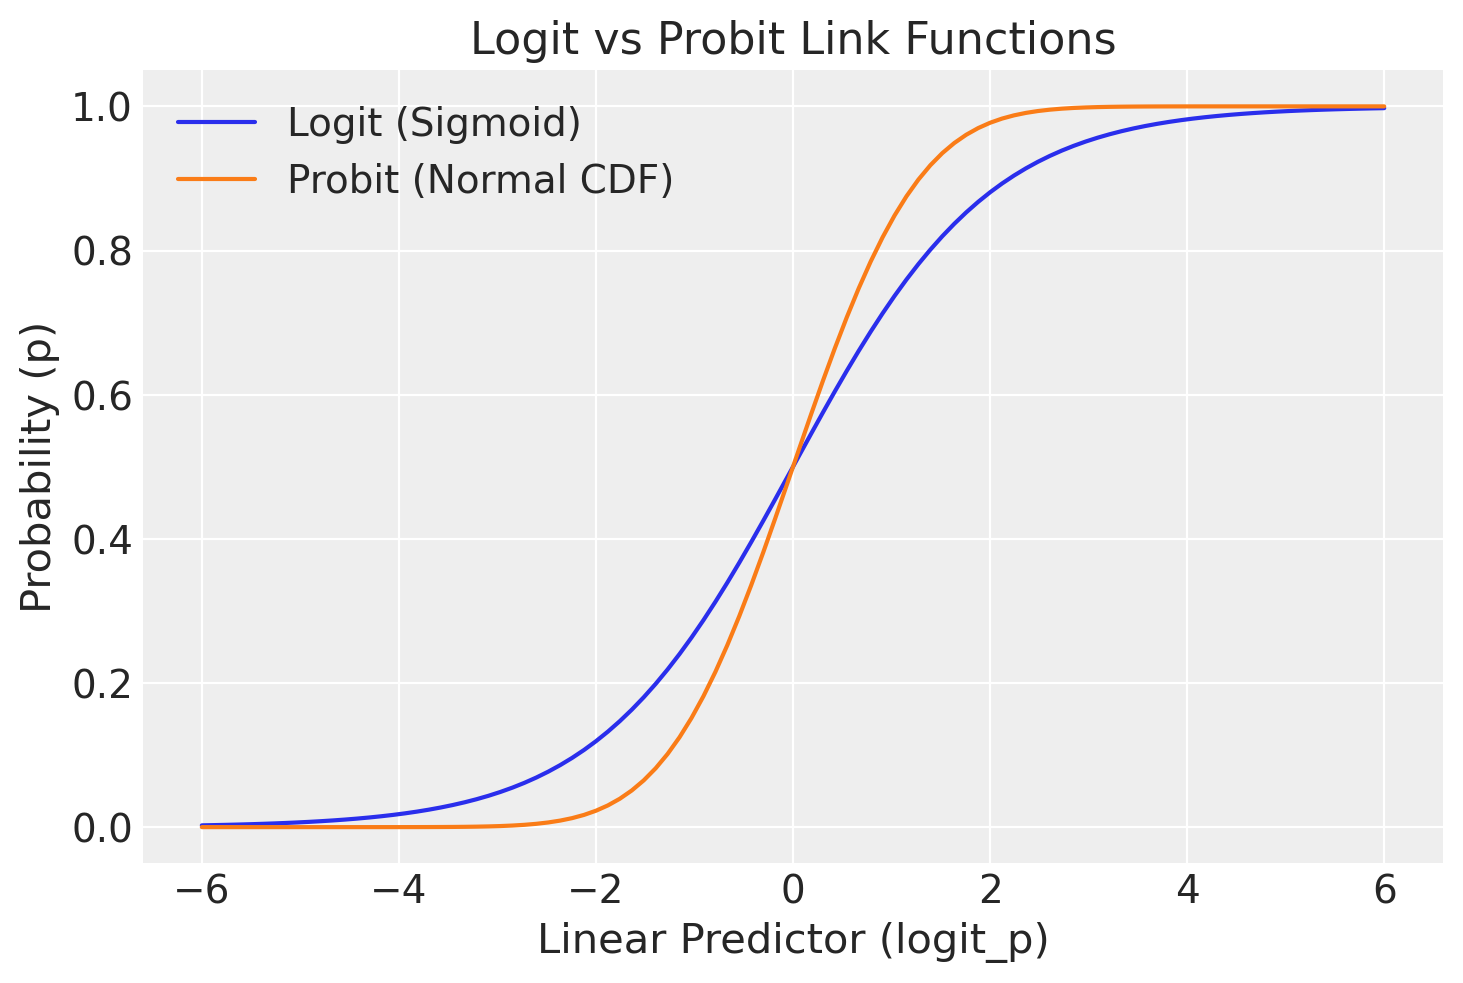

In [19]:
logit_p = np.linspace(-6, 6, 100)
p_logit = expit(logit_p)  # sigmoid
p_probit = norm.cdf(logit_p)  # probit approximation

plt.plot(logit_p, p_logit, label="Logit (Sigmoid)")
plt.plot(logit_p, p_probit, label="Probit (Normal CDF)")
plt.xlabel("Linear Predictor (logit_p)")
plt.ylabel("Probability (p)")
plt.legend()
plt.title("Logit vs Probit Link Functions")
plt.show()

In [20]:
log_reg_probit= pm.Model()

with log_reg_probit: #creating a context manager
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    
    logit_p = beta_0 + beta_1 * np.log(df['conc'])
    #using a probit link (normal cdf )
    p = pm.Deterministic("p", pm.math.invprobit(logit_p)) #invprobit is the same as guassian cdf..
    Nsurv_obs = pm.Binomial("Nsurv", n=df['N0'], p=p, observed=df['Nsurv'])

    log_reg_probit_trace = pm.sample(5000, tune=1000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


In [21]:
# (we could also extract these directly from ArviZ Summary..)
beta_0_logit_mean = log_reg_logit_trace.posterior["beta_0"].mean().values
beta_1_logit_mean = log_reg_logit_trace.posterior["beta_1"].mean().values

In [22]:
beta_0_probit_mean= log_reg_probit_trace.posterior["beta_0"].mean().values
beta_1_probit_mean= log_reg_probit_trace.posterior["beta_1"].mean().values


In [23]:
conc_range = np.linspace(df['conc'].min(), df['conc'].max(), 2000)


In [24]:
logit_p_probit = beta_0_probit_mean + beta_1_probit_mean * np.log(conc_range)
logit_p_logit = beta_0_logit_mean + beta_1_logit_mean * np.log(conc_range)

p_probit = norm.cdf(logit_p_probit)
p_logit = expit(logit_p_logit)



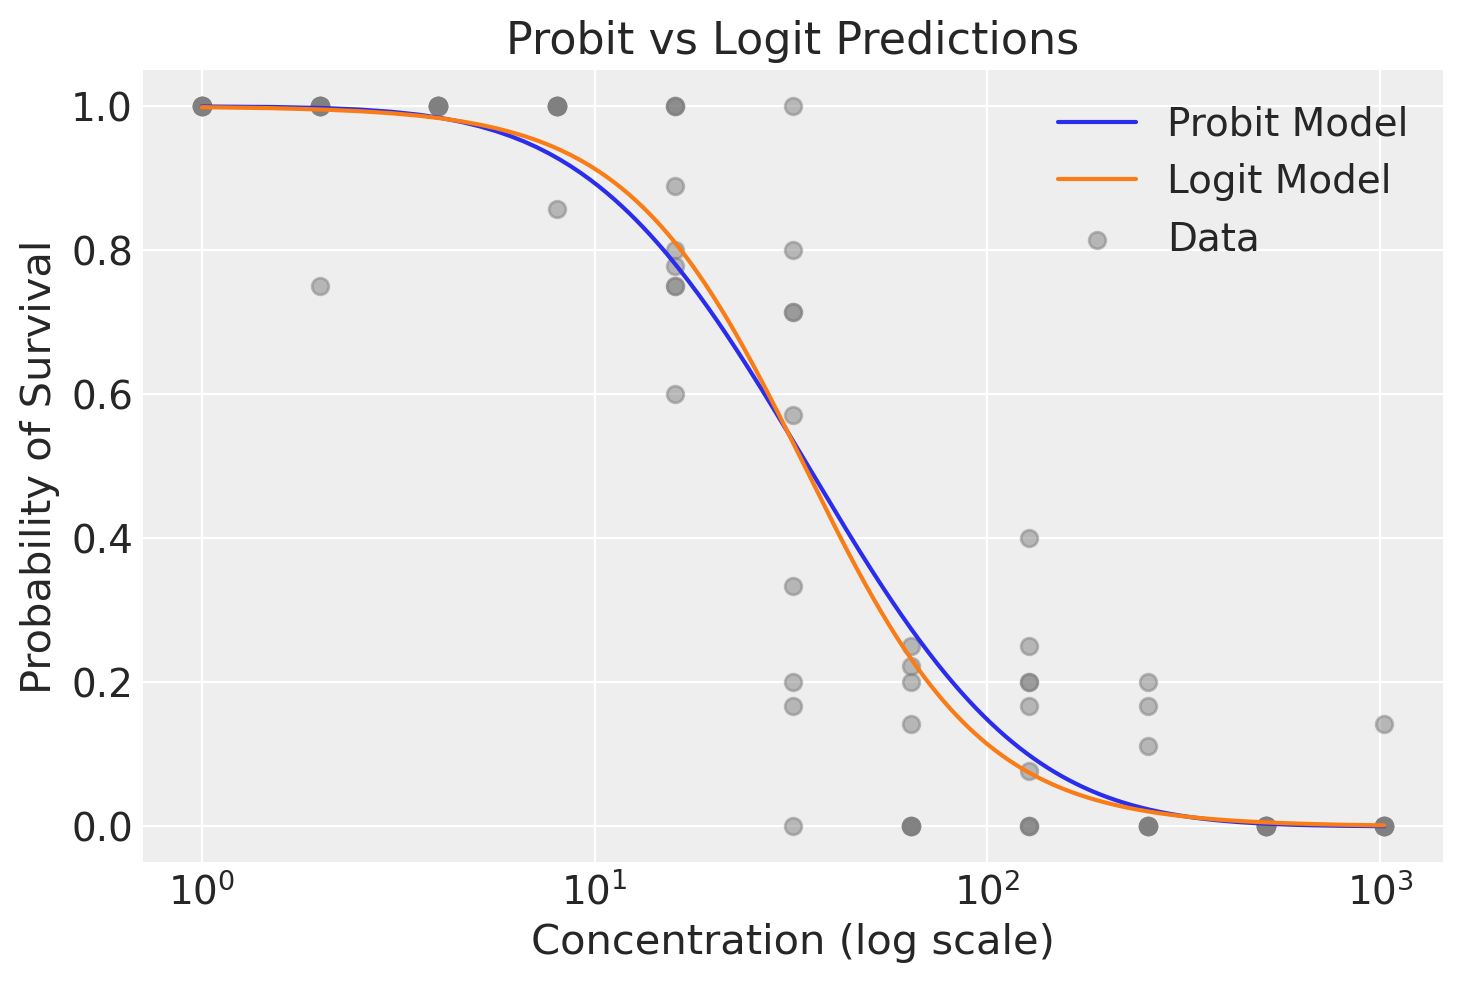

In [25]:
plt.plot(conc_range, p_probit, label="Probit Model")
plt.plot(conc_range, p_logit, label="Logit Model")
plt.scatter(df['conc'], df['Nsurv']/df['N0'], color='gray', alpha=0.5, label="Data")
plt.xlabel("Concentration (log scale)")
plt.xscale("log")
plt.ylabel("Probability of Survival")
plt.legend()
plt.title("Probit vs Logit Predictions")
plt.show()

Sampling: [Nsurv]


Sampling: [Nsurv]


<Axes: xlabel='Nsurv / Nsurv'>

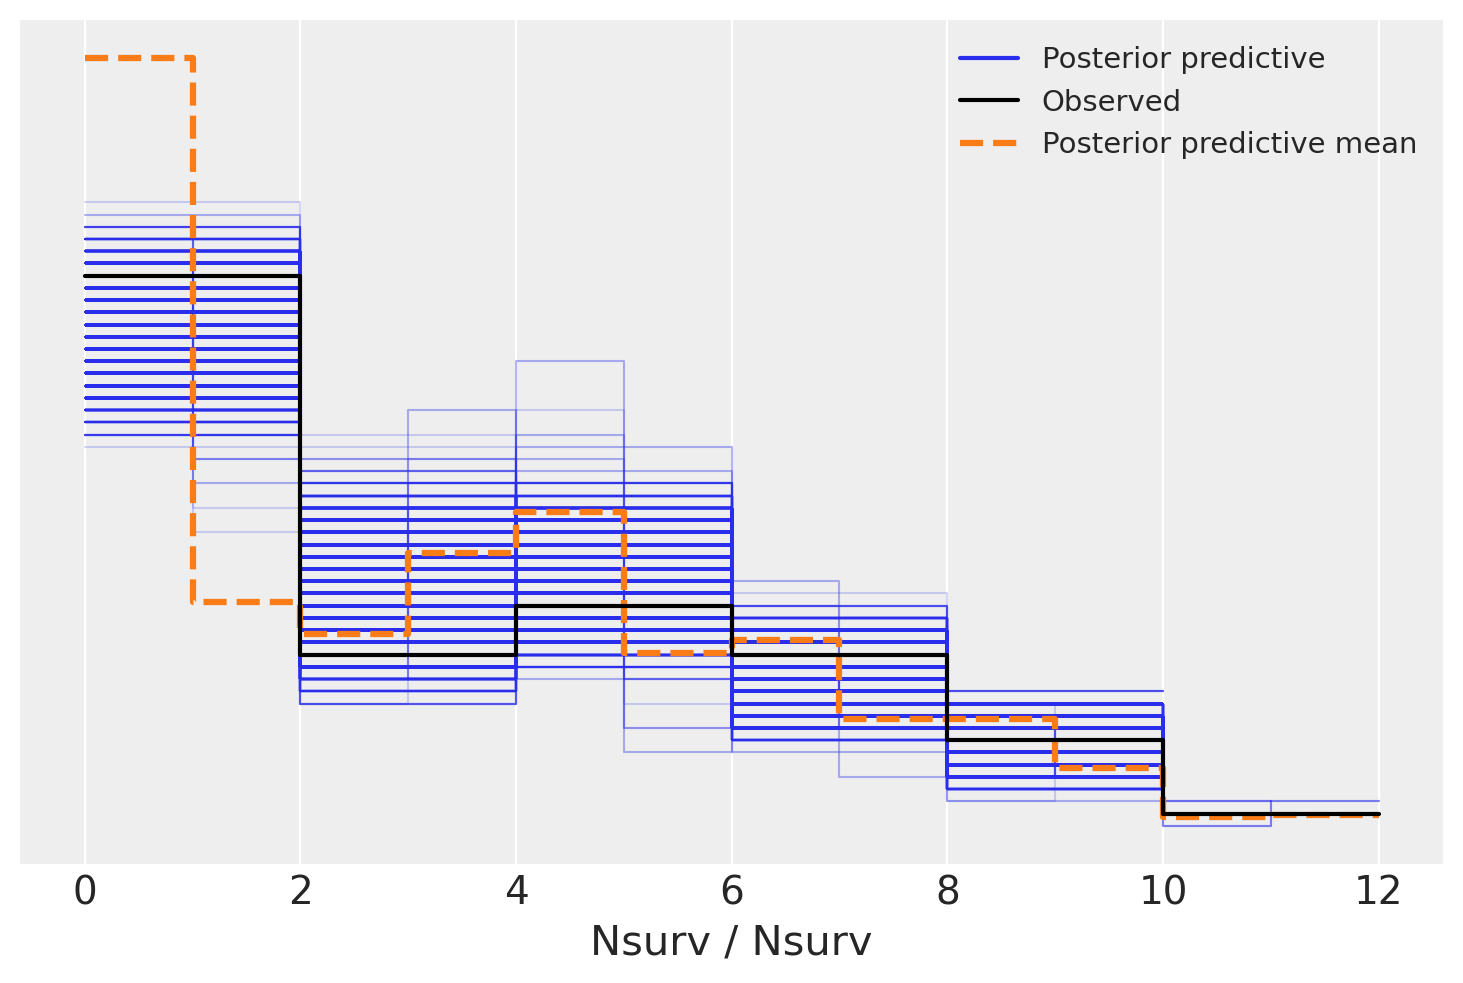

In [26]:
with log_reg_probit:  # probit model
    ppc_probit = pm.sample_posterior_predictive(log_reg_probit_trace)
with log_reg_logit:
    ppc_logit = pm.sample_posterior_predictive(log_reg_logit_trace)

az.plot_ppc(ppc_probit, group="posterior")


    the observed data consistently lies within the range of posterior predictions but not so well with the mean prediction in the beginning , we can say the model is somewhat well-calibrated. 
    (Significant deviations might indicate that the model does not adequately capture the data structure.)

<Axes: xlabel='Nsurv / Nsurv'>

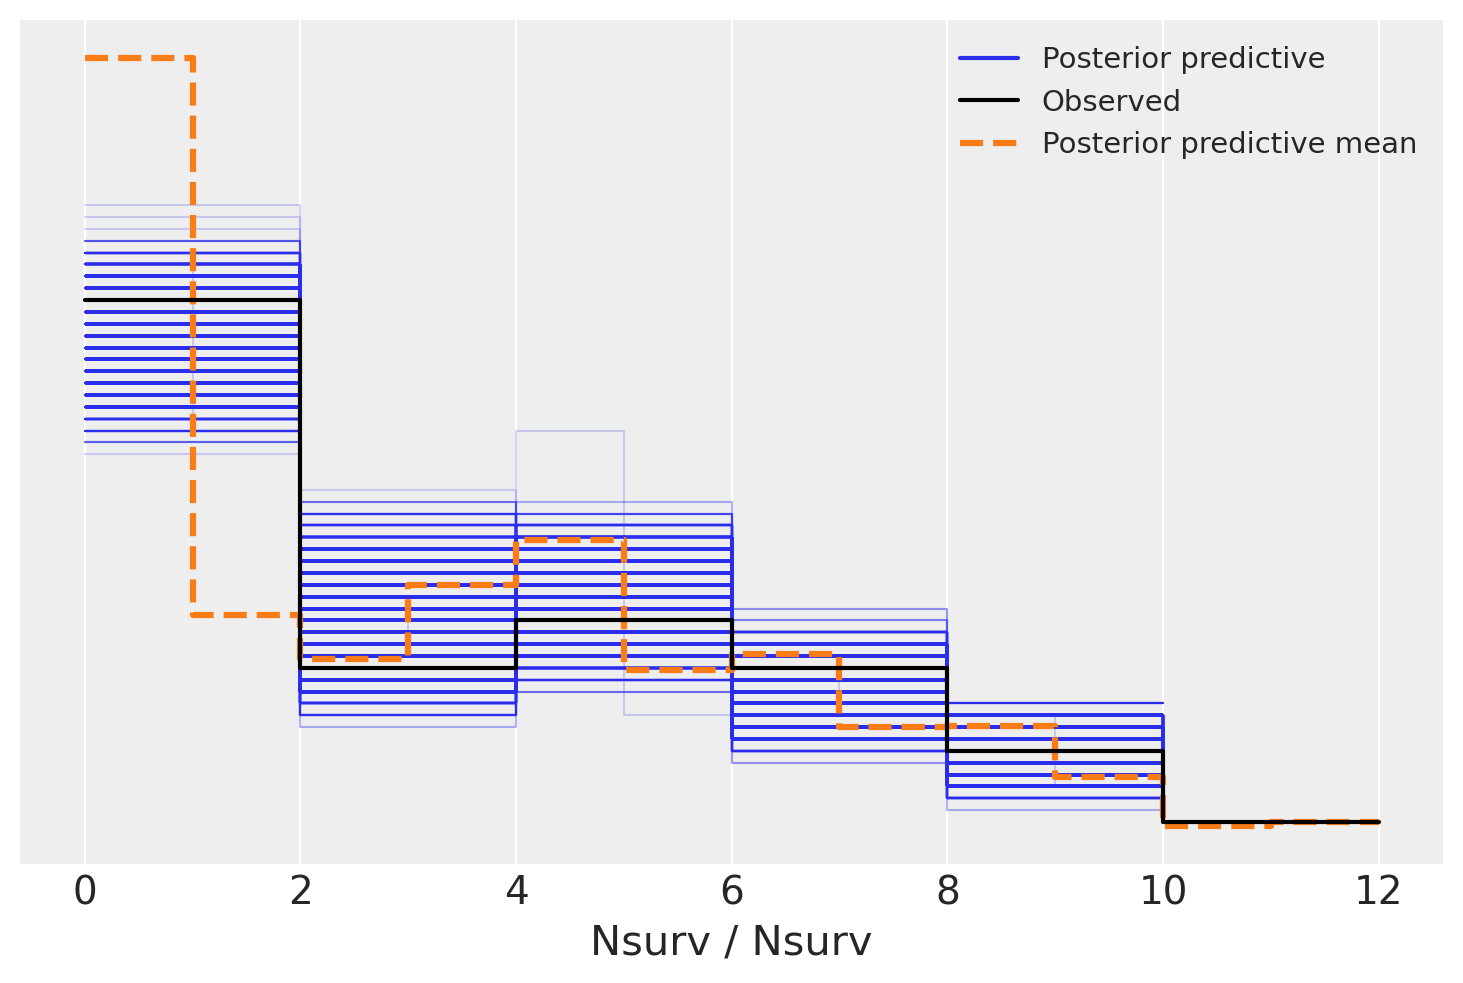

In [27]:
az.plot_ppc(ppc_logit, group="posterior")


In [28]:
# log_reg_logit_trace.posterior['beta_0']

In [29]:
from scipy.stats import t
import pytensor.tensor as tt

def student_t_cdf(x, nu):
    # Standard Student’s t CDF: t.cdf(x, df=nu)
    # Using the regularized incomplete beta function
    t = x / tt.sqrt(nu / (nu + x**2))
    cond = tt.switch(x >= 0, 1, 0)
    z = nu / (nu + x**2)
    I = 0.5 * tt.betainc(nu/2, 0.5, z)
    return cond + (1 - 2 * cond) * I

log_reg_robit = pm.Model()
with log_reg_robit:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    nu = pm.Gamma("nu", alpha=2, beta=0.1)  # Degree of freedom parameter

    # Robit link function: robit(p) = StudentT_cdf(log(conc), nu)
    linear_pred = beta_0 + beta_1 * np.log(df['conc'])

    robit_p = pm.Deterministic("p", student_t_cdf(linear_pred, nu))    
    Nsurv_obs = pm.Binomial("Nsurv", n=df['N0'], p=robit_p, observed=df['Nsurv'])

    log_reg_robit_trace = pm.sample(5000, tune=1000, return_inferencedata=True, target_accept=0.95)

/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarnin

/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation.

In [30]:
az.summary(log_reg_robit_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,7.159,2.412,3.593,11.588,0.048,0.036,2834.0,2685.0,1.0
beta_1,-2.040,0.690,-3.289,-1.008,0.014,0.010,2821.0,2683.0,1.0
nu,3.100,3.382,0.796,6.707,0.070,0.049,2810.0,3171.0,1.0
p[0],0.991,0.006,0.980,1.000,0.000,0.000,3450.0,3971.0,1.0
p[1],0.986,0.007,0.974,0.998,0.000,0.000,3873.0,5289.0,1.0
...,...,...,...,...,...,...,...,...,...
p[94],0.171,0.044,0.098,0.255,0.001,0.000,4007.0,5491.0,1.0
p[95],0.060,0.015,0.035,0.089,0.000,0.000,7538.0,8779.0,1.0
p[96],0.027,0.008,0.012,0.042,0.000,0.000,6598.0,9561.0,1.0
p[97],0.015,0.007,0.003,0.028,0.000,0.000,4001.0,5863.0,1.0


In [31]:

print(pm.__version__)  
import pytensor
print(pytensor.__version__)

5.6.1
2.12.3


In [32]:
# beta_0_robit_mean = log_reg_robit_trace.posterior["beta_0"].mean().values
# beta_1_robit_mean = log_reg_robit_trace.posterior["beta_1"].mean().values

In [33]:
robit_summary = az.summary(log_reg_robit_trace)
beta_0_robit_mean = robit_summary.loc['beta_0', 'mean']
beta_1_robit_mean = robit_summary.loc['beta_1', 'mean']
nu_robit_mean = robit_summary.loc['nu', 'mean']

In [34]:
logit_p_robit = beta_0_robit_mean + beta_1_robit_mean * np.log(conc_range)
p_robit = t.cdf(logit_p_robit, df=nu_robit_mean)  # Robit: Student’s t CDF

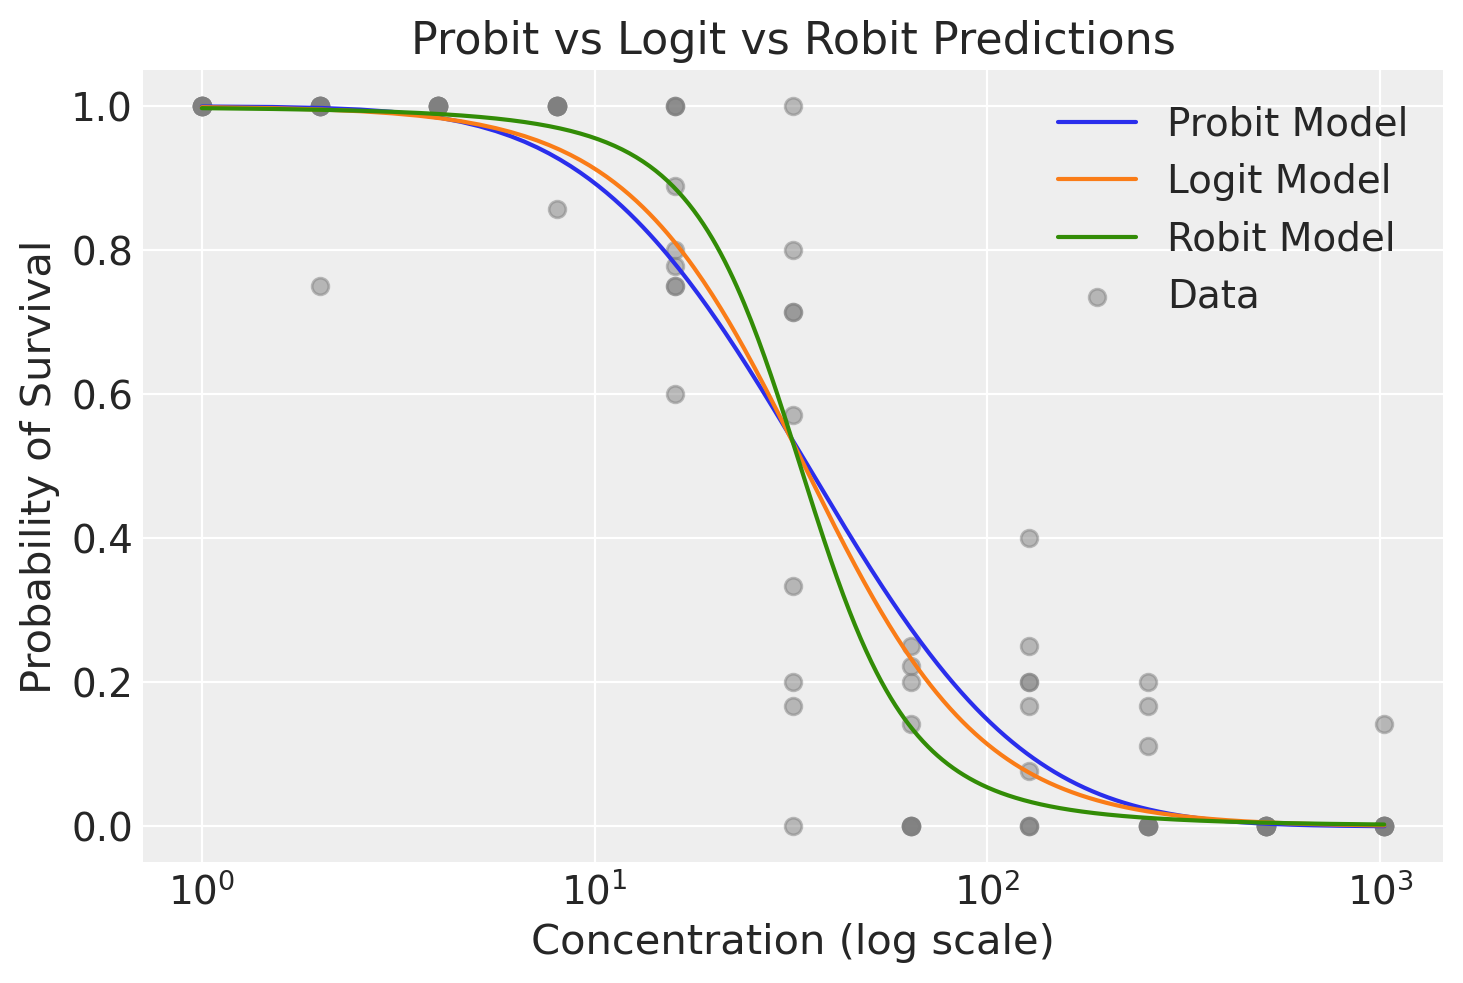

In [35]:
plt.plot(conc_range, p_probit, label="Probit Model")
plt.plot(conc_range, p_logit, label="Logit Model")
plt.plot(conc_range, p_robit, label="Robit Model")
plt.scatter(df['conc'], df['Nsurv']/df['N0'], color='gray', alpha=0.5, label="Data")
plt.xlabel("Concentration (log scale)")
plt.xscale("log")
plt.ylabel("Probability of Survival")
plt.legend()
plt.title("Probit vs Logit vs Robit Predictions")
plt.show()

    we notice that the Robit link allows a more steeper line (because it effectively downweights the influence of points that do not appear to fit the model.)

### Explore the space of priors ( since  the init normal distribution is weakly informative )

In [41]:
!pip install aesara

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.1 MB/s eta 0:00:00a 0:00:01


In [61]:
f_conc = pm.Model()
with f_conc:
    d = pm.Beta("d", alpha=2, beta=1)  
    c = pm.Beta("c", alpha=1, beta=2)  
    b = pm.HalfNormal("b", sigma=2)    
    e = pm.LogNormal("e", mu=0, sigma=2)  

    # Log-logistic function: f(conc) = (d - c) / (1 + (conc / e)^b) + c
    conc = df['conc'].values  # Concentration values
    p = pm.Deterministic("p", (d - c) / (1 + (conc / e)**b) + c)

    # Likelihood (Binomial distribution)
    Nsurv_obs = pm.Binomial("Nsurv", n=df['N0'], p=p, observed=df['Nsurv'])

    # Sampling from the posterior
    f_conc_trace = pm.sample(5000, tune=1000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, c, b, e]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


In [62]:
summary = az.summary(f_conc_trace)


In [63]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.988,0.008,0.973,1.000,0.000,0.000,10988.0,7086.0,1.0
c,0.034,0.015,0.007,0.062,0.000,0.000,9918.0,7334.0,1.0
b,2.658,0.419,1.919,3.431,0.004,0.003,10825.0,13282.0,1.0
e,31.490,2.719,26.579,36.705,0.025,0.018,12011.0,12341.0,1.0
p[0],0.988,0.008,0.973,1.000,0.000,0.000,11160.0,7458.0,1.0
...,...,...,...,...,...,...,...,...,...
p[94],0.165,0.038,0.096,0.237,0.000,0.000,11310.0,13508.0,1.0
p[95],0.061,0.015,0.034,0.089,0.000,0.000,22055.0,16032.0,1.0
p[96],0.040,0.014,0.016,0.065,0.000,0.000,13076.0,11060.0,1.0
p[97],0.036,0.015,0.009,0.063,0.000,0.000,10377.0,8013.0,1.0


In [ ]:
mean_d = summary.loc['d', 'mean']
mean_e = summary.loc['e', 'mean']
mean_b = summary.loc['b', 'mean']
mean_c = summary.loc['c', 'mean']


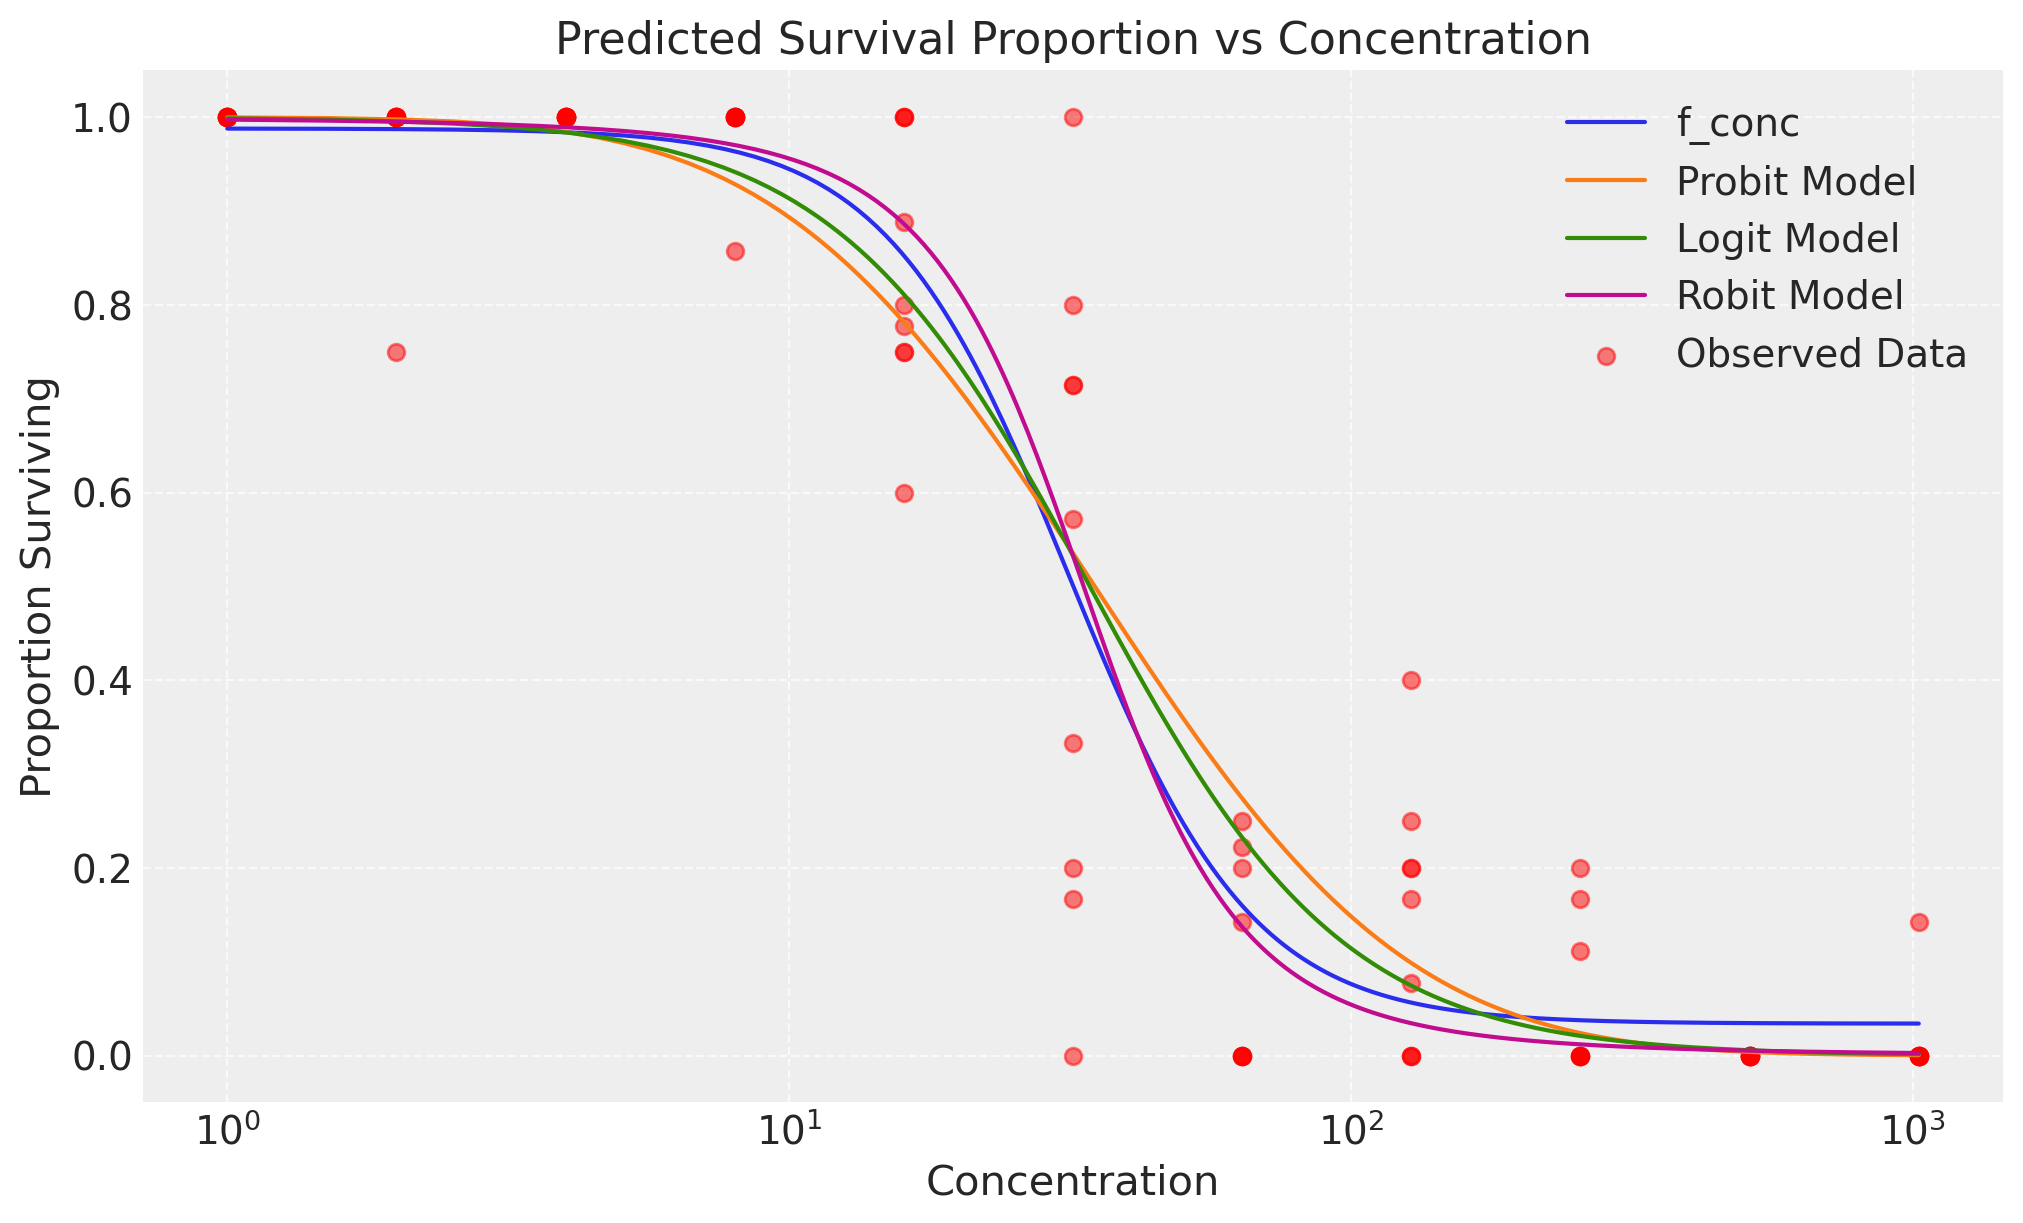

In [72]:
f_conc = (mean_d - mean_c) / (1 + (conc_range / mean_e)**mean_b) + mean_c

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(conc_range, f_conc, label='f_conc')
plt.plot(conc_range, p_probit, label="Probit Model")
plt.plot(conc_range, p_logit, label="Logit Model")
plt.plot(conc_range, p_robit, label="Robit Model")
plt.scatter(df['conc'], df['Nsurv']/df['N0'], color='red', alpha=0.5, label='Observed Data')  # Optional: plot observed data
plt.xlabel('Concentration')
plt.xscale("log")
plt.ylabel('Proportion Surviving')
plt.title('Predicted Survival Proportion vs Concentration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.plot(conc_range, p_probit, label="Probit Model")
plt.plot(conc_range, p_logit, label="Logit Model")
plt.plot(conc_range, p_robit, label="Robit Model")
plt.scatter(df['conc'], df['Nsurv']/df['N0'], color='gray', alpha=0.5, label="Data")
plt.xlabel("Concentration (log scale)")
plt.xscale("log")
plt.ylabel("Probability of Survival")
plt.legend()
plt.title("Probit vs Logit vs Robit Predictions")
plt.show()